In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [10]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> GRU 1</h1>

In [11]:
from tensorflow.keras.layers import GRU
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               106752    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 140422 (548.52 KB)
Trainable params: 140422 (548.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 8s 40ms/step - loss: 1.2191 - accuracy: 0.4948 - val_loss: 1.0082 - val_accuracy: 0.5703
Epoch 2/10
58/58 [==============================] - 1s 19ms/step - loss: 0.9270 - accuracy: 0.6133 - val_loss: 0.7659 - val_accuracy: 0.6813
Epoch 3/10
58/58 [==============================] - 1s 18ms/step - loss: 0.5531 - accuracy: 0.7757 - val_loss: 0.3867 - val_accuracy: 0.8590
Epoch 4/10
58/58 [==============================] - 1s 17ms/step - loss: 0.3111 - accuracy: 0.8859 - val_loss: 0.2394 - val_accuracy: 0.9062
Epoch 5/10
58/58 [==============================] - 1s 20ms/step - loss: 0.2362 - accuracy: 0.9106 - val_loss: 0.1720 - val_accuracy: 0.9343
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1839 - accuracy: 0.9304 - val_loss: 0.1695 - val_accuracy: 0.9252
Epoch 7/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1533 - accuracy: 0.9369 - val_loss: 0.1401 - val_accuracy: 0.9383
Epoch 8/10
58

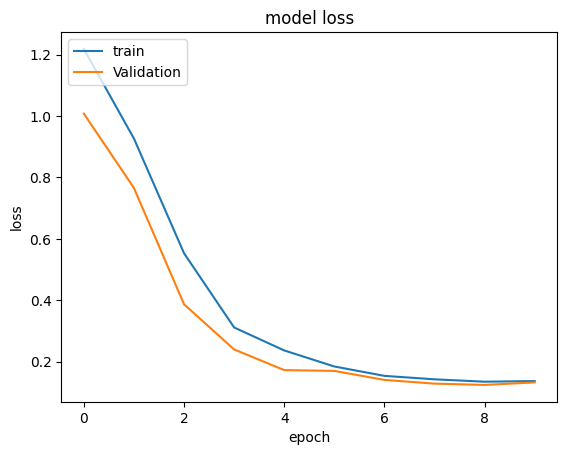

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

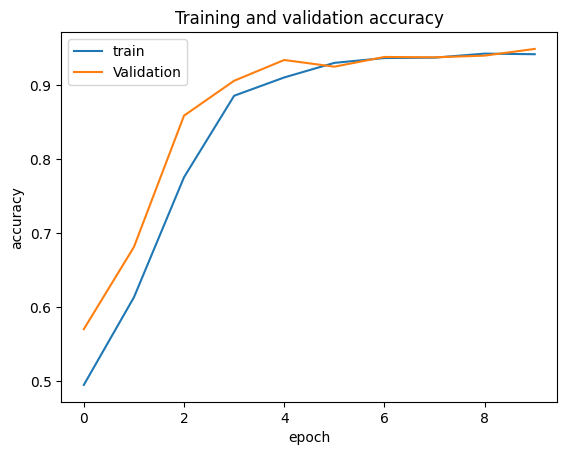

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[438   4  54   0   0   0]
 [ 14 425  32   0   0   0]
 [  2   0 418   0   0   0]
 [  0   9   1 421  60   0]
 [  2   0   0 131 399   0]
 [  0  27   0   0   0 510]]
0.8859857482185273
0.8862022572641353
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       496
           1       0.91      0.90      0.91       471
           2       0.83      1.00      0.90       420
           3       0.76      0.86      0.81       491
           4       0.87      0.75      0.81       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

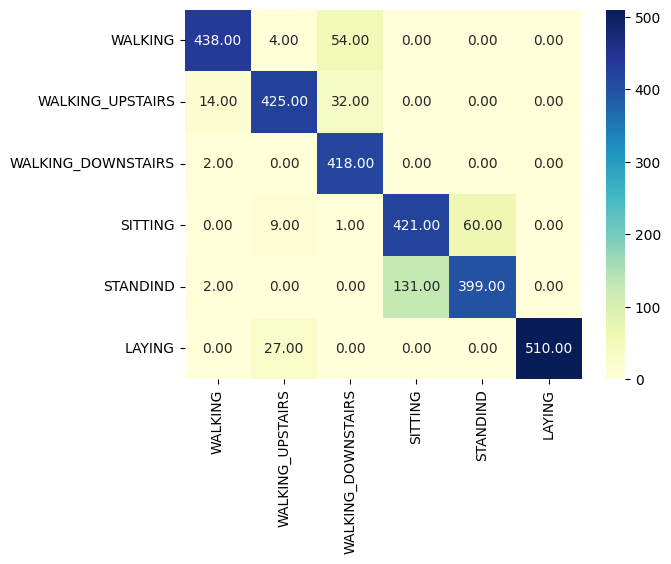

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU 2</h1>

In [16]:
# Model 2
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 11s 60ms/step - loss: 1.1501 - accuracy: 0.5126 - val_loss: 0.9614 - val_accuracy: 0.5966
Epoch 2/10
58/58 [==============================] - 2s 37ms/step - loss: 0.7343 - accuracy: 0.6930 - val_loss: 0.5194 - val_accuracy: 0.7783
Epoch 3/10
58/58 [==============================] - 2s 37ms/step - loss: 0.3111 - accuracy: 0.8819 - val_loss: 0.1638 - val_accuracy: 0.9320
Epoch 4/10
58/58 [==============================] - 2s 37ms/step - loss: 0.1619 - accuracy: 0.9381 - val_loss: 0.1326 - val_accuracy: 0.9447
Epoch 5/10
58/58 [==============================] - 2s 40ms/step - loss: 0.1436 - accuracy: 0.9404 - val_loss: 0.1241 - val_accuracy: 0.9529
Epoch 6/10
58/58 [==============================] - 2s 40ms/step - loss: 0.1405 - accuracy: 0.9429 - val_loss: 0.1224 - val_accuracy: 0.9569
Epoch 7/10
58/58 [==============================] - 2s 40ms/step - loss: 0.1277 - accuracy: 0.9470 - val_loss: 0.1141 - val_accuracy: 0.9560
Epoch 8/10
5

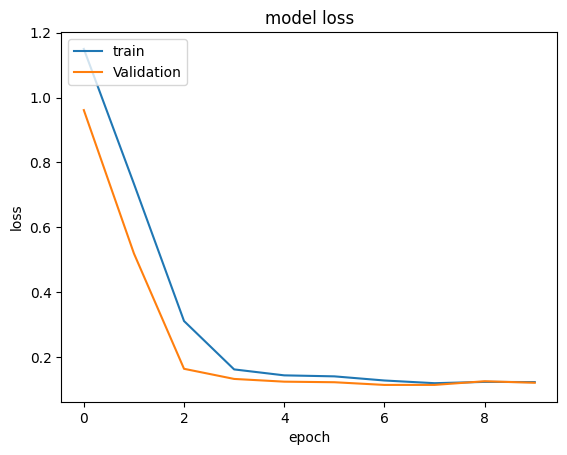

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

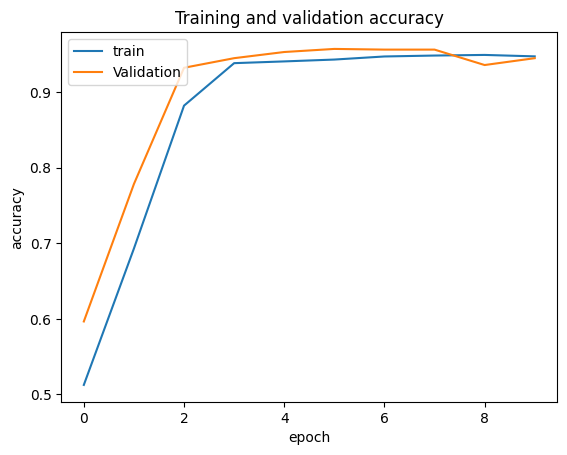

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 10ms/step
[[470   0  26   0   0   0]
 [ 15 435  21   0   0   0]
 [  0   9 411   0   0   0]
 [  0  24   0 335 132   0]
 [  0   0   0  42 490   0]
 [  0   0   0   0   0 537]]
0.9087207329487614
0.9069068697493488
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.93      0.92      0.93       471
           2       0.90      0.98      0.94       420
           3       0.89      0.68      0.77       491
           4       0.79      0.92      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

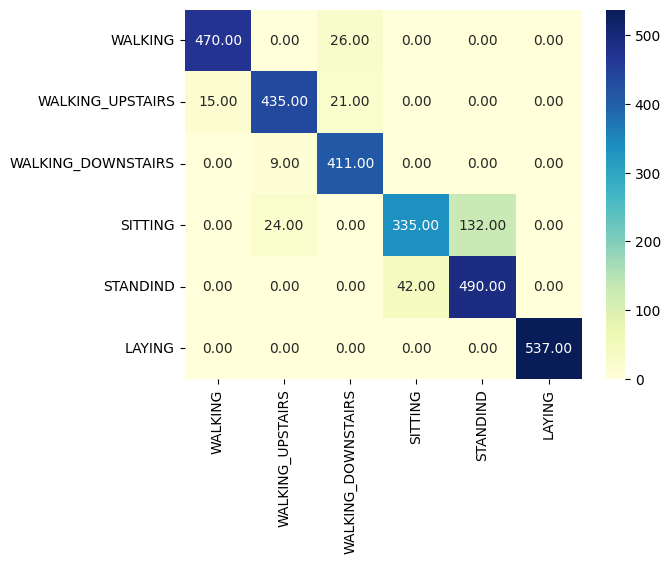

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 3</h1>

In [21]:
# Model 3
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 18s 97ms/step - loss: 1.1331 - accuracy: 0.5192 - val_loss: 0.9543 - val_accuracy: 0.5947
Epoch 2/10
58/58 [==============================] - 3s 60ms/step - loss: 0.6706 - accuracy: 0.7144 - val_loss: 0.5259 - val_accuracy: 0.8037
Epoch 3/10
58/58 [==============================] - 3s 59ms/step - loss: 0.3270 - accuracy: 0.8740 - val_loss: 0.1888 - val_accuracy: 0.9320
Epoch 4/10
58/58 [==============================] - 3s 59ms/step - loss: 0.1703 - accuracy: 0.9366 - val_loss: 0.1419 - val_accuracy: 0.9356
Epoch 5/10
58/58 [==============================] - 4s 65ms/step - loss: 0.1511 - accuracy: 0.9426 - val_loss: 0.1368 - val_accuracy: 0.9501
Epoch 6/10
58/58 [==============================] - 3s 60ms/step - loss: 0.1458 - accuracy: 0.9427 - val_loss: 0.1334 - val_accuracy: 0.9474
Epoch 7/10
58/58 [==============================] - 3s 59ms/step - loss: 0.1284 - accuracy: 0.9472 - val_loss: 0.1182 - val_accuracy: 0.9560
Epoch 8/10
5

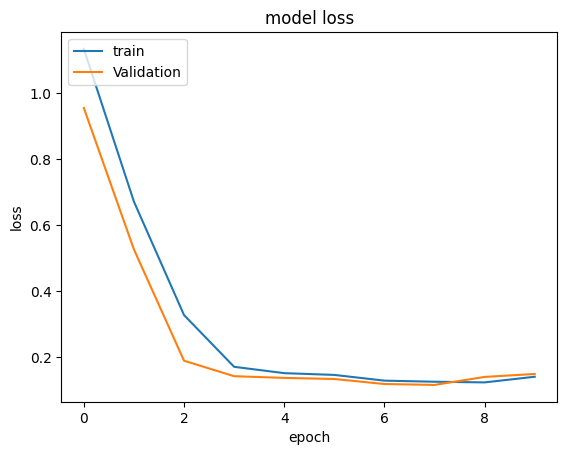

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

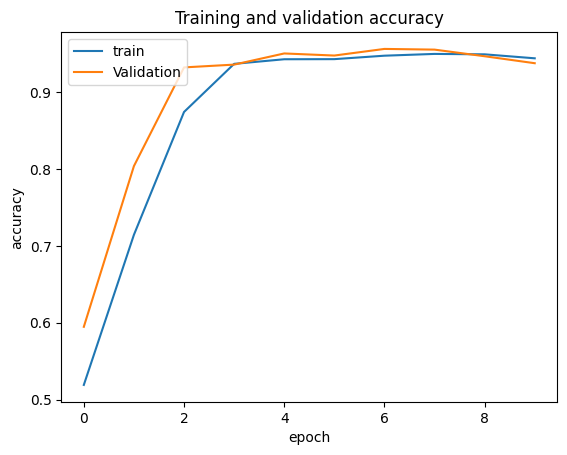

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 13ms/step
[[474   1  21   0   0   0]
 [ 43 411  16   0   1   0]
 [  3   2 415   0   0   0]
 [  0  20   0 347 119   5]
 [  0   0   0  43 489   0]
 [  0   0   0   0   0 537]]
0.9070240922972514
0.9052153451939268
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       496
           1       0.95      0.87      0.91       471
           2       0.92      0.99      0.95       420
           3       0.89      0.71      0.79       491
           4       0.80      0.92      0.86       532
           5       0.99      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

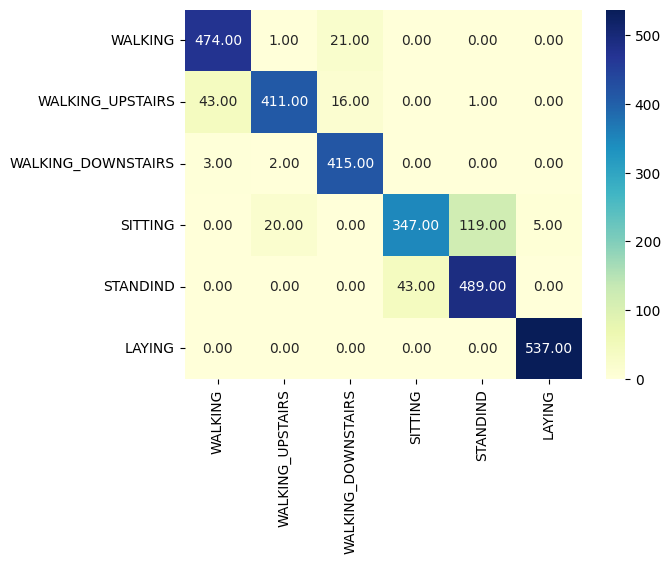

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> GRU 4</h1>

In [26]:
# Model 4
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                      

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 22s 132ms/step - loss: 1.1565 - accuracy: 0.5087 - val_loss: 0.9628 - val_accuracy: 0.6115
Epoch 2/10
58/58 [==============================] - 5s 82ms/step - loss: 0.7014 - accuracy: 0.6945 - val_loss: 0.5507 - val_accuracy: 0.7765
Epoch 3/10
58/58 [==============================] - 5s 84ms/step - loss: 0.3742 - accuracy: 0.8594 - val_loss: 0.2331 - val_accuracy: 0.9180
Epoch 4/10
58/58 [==============================] - 5s 80ms/step - loss: 0.1883 - accuracy: 0.9294 - val_loss: 0.1300 - val_accuracy: 0.9461
Epoch 5/10
58/58 [==============================] - 5s 85ms/step - loss: 0.1533 - accuracy: 0.9396 - val_loss: 0.1450 - val_accuracy: 0.9374
Epoch 6/10
58/58 [==============================] - 5s 83ms/step - loss: 0.1360 - accuracy: 0.9457 - val_loss: 0.1204 - val_accuracy: 0.9415
Epoch 7/10
58/58 [==============================] - 5s 80ms/step - loss: 0.1463 - accuracy: 0.9422 - val_loss: 0.1623 - val_accuracy: 0.9374
Epoch 8/10


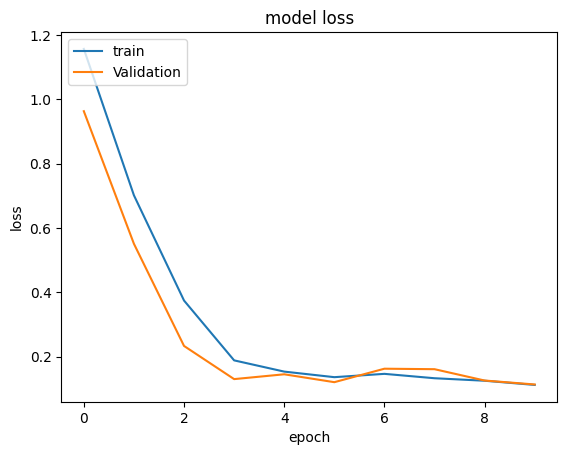

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

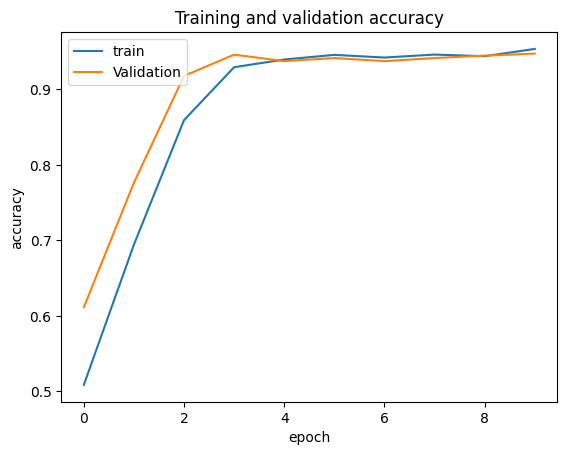

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 21ms/step
[[483   0  12   1   0   0]
 [ 22 422  26   0   1   0]
 [  2   7 411   0   0   0]
 [  0  19   0 363 104   5]
 [  0   9   0  52 471   0]
 [  0   0   0   0   0 537]]
0.9117746861214795
0.9104776576545809
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       496
           1       0.92      0.90      0.91       471
           2       0.92      0.98      0.95       420
           3       0.87      0.74      0.80       491
           4       0.82      0.89      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

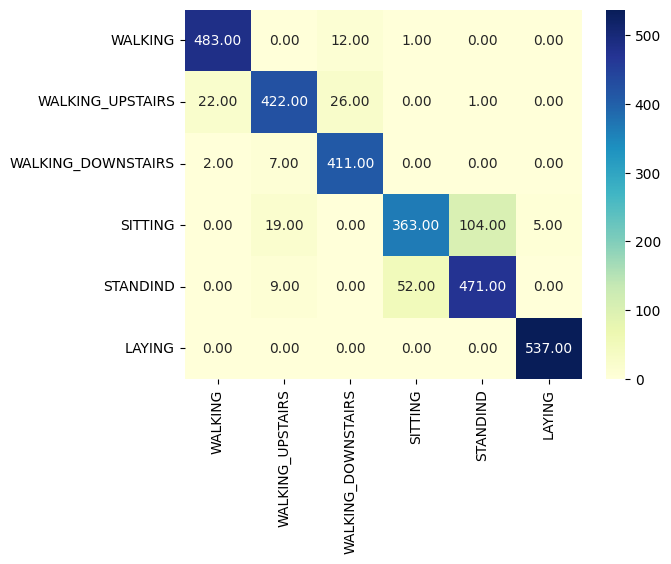

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 5</h1>

In [31]:
# Model 5
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 128, 256)          106752    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 26s 169ms/step - loss: 1.1176 - accuracy: 0.5162 - val_loss: 0.9534 - val_accuracy: 0.5789
Epoch 2/10
58/58 [==============================] - 6s 103ms/step - loss: 0.7270 - accuracy: 0.6873 - val_loss: 0.5522 - val_accuracy: 0.7788
Epoch 3/10
58/58 [==============================] - 6s 101ms/step - loss: 0.3468 - accuracy: 0.8686 - val_loss: 0.1734 - val_accuracy: 0.9383
Epoch 4/10
58/58 [==============================] - 6s 101ms/step - loss: 0.1797 - accuracy: 0.9297 - val_loss: 0.1343 - val_accuracy: 0.9470
Epoch 5/10
58/58 [==============================] - 6s 102ms/step - loss: 0.1522 - accuracy: 0.9402 - val_loss: 0.1396 - val_accuracy: 0.9370
Epoch 6/10
58/58 [==============================] - 6s 104ms/step - loss: 0.1442 - accuracy: 0.9416 - val_loss: 0.1353 - val_accuracy: 0.9488
Epoch 7/10
58/58 [==============================] - 6s 102ms/step - loss: 0.1321 - accuracy: 0.9453 - val_loss: 0.1426 - val_accuracy: 0.9370
Epoch

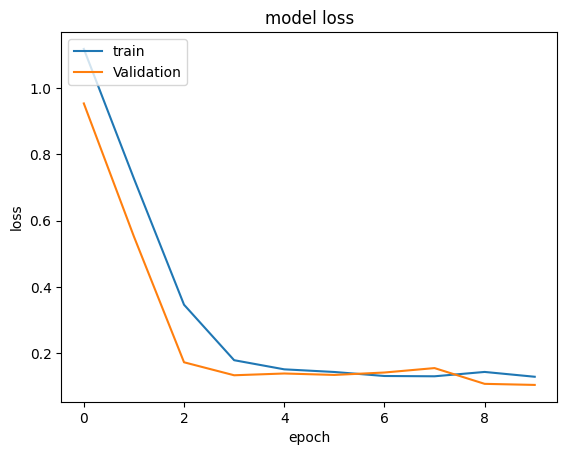

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

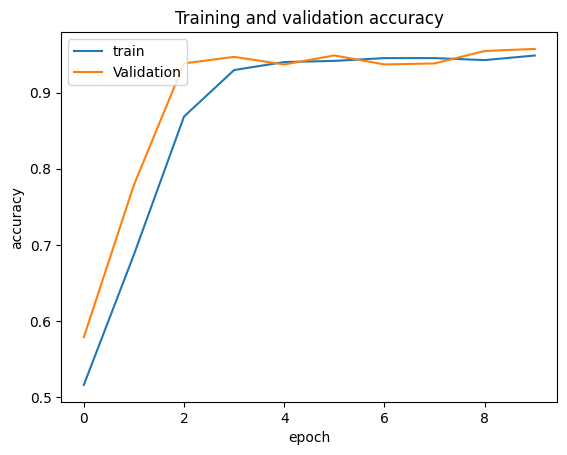

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 21ms/step
[[485   6   5   0   0   0]
 [  6 450  15   0   0   0]
 [  2  17 401   0   0   0]
 [  0  20   0 418  48   5]
 [  0   2   0 112 418   0]
 [  0   0   0   0   0 537]]
0.9192399049881235
0.9189013971942833
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       496
           1       0.91      0.96      0.93       471
           2       0.95      0.95      0.95       420
           3       0.79      0.85      0.82       491
           4       0.90      0.79      0.84       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

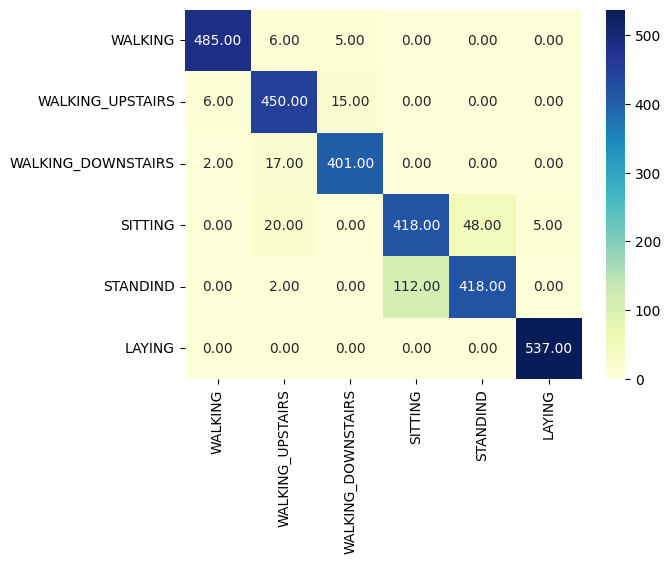

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')